In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open("tRNA.txt","r") as f:
    lines = f.readlines()
    output = []
    output.append(f"Sequence Name,tRNA #,tRNA Begin,Bounds End,tRNA Type,AntiCodon,Intron Begin,Bounds End,Inf Score,Isotype CM,Isotype Score\n")
    for line in lines[3:]:
        line = [x.strip() for x in line.split("\t") if x != " "]
        to_output = []
        for x in line:
            to_output += x.split("\t")
        #print(to_output)
        output.append(f'{",".join(to_output[:-1])}\n')

with open("tRNA.csv","w") as f:
    f.writelines(output)

tRNA_df = pd.read_csv("tRNA.csv",)

In [3]:
codon_df = pd.read_csv("codons.csv")

In [4]:
codon_to_aa = codon_df.groupby('codon')['aminoacid'].apply(list).to_dict()
codon_to_aa = {x:y[0] for x,y in codon_to_aa.items()}


In [5]:

heatmap_df = pd.DataFrame(index=sorted(codon_df["codon"]), columns=sorted(codon_df["codon"]))
heatmap_df = heatmap_df.fillna(0)

/tmp/ipykernel_23758/1950807390.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_df = heatmap_df.fillna(0)


In [6]:
# I - Inosine (modif A)
TadA = True
# k2C - Lysidine
TilS = True
# xm5s2U: 5-(Carboxymethylaminomethyl)-2-thiouridine
mnmGorE = True
# xm5Um: 5-(Carboxymethylaminomethyl)-2′-O-methyluridine
TrmL = True
# Um: 2′-O-methyluridine
trmJ = True
# xm5U: 5-(Carboxymethylaminomethyl)uridine
trmA = True
# xo5U: 5-Hydroxyuridine
trhO = True

In [7]:
Wobble_pair = {
    "A":["T","C","G"],
    "T":["A","G","T"],
    "C":["G"],
    "G":["C","T"],
    
    "I":["A","C","U"],
    "k2C":["A"],
    "xm5s2U":["A"],
    "xm5Um":["A"],
    "Um":["A"],
    "xm5U": ["A"],
    "xo5U": ["T","A","G"]
}
from itertools import combinations as find_combi

for anticodon in tRNA_df["AntiCodon"]:
    try: 
        codon_base_pair = "".join([Wobble_pair[x][0] for x in anticodon][::-1])
        """
        print(f"A 5' - {anticodon} - 3'")
        print(f"C 3' - {codon_base_pair[::-1]} - 5'")
        print(f"C 5' - {codon_base_pair} - 3'\n")
        """
        # Normal wooble 
        codons_reco  = [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair[anticodon[0]]]

        
        #Non-canonanical bases wooble 
        if TadA and anticodon[0] == "A":
            codons_reco  += [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair["I"]]
        if TilS and anticodon[0] == "C":
            codons_reco  += [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair["k2C"]]

        elif anticodon[0] == "T":
            if mnmGorE:
                codons_reco  += [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair["xm5s2U"]]
            if TrmL:
                codons_reco  += [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair["xm5Um"]]
            if trmJ:
                codons_reco  += [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair["Um"]]
            if trmA:
                codons_reco  += [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair["xm5U"]]
            if trhO:
                codons_reco  += [f"{codon_base_pair[:-1]}{x}" for x in Wobble_pair["xo5U"]]
        

        for combi in find_combi(codons_reco,2):
            codon1,codon2 = combi
            heatmap_df.loc[codon1,codon2] += 1
            heatmap_df.loc[codon2,codon1] += 1

    except KeyError:
        print(f"[ERROR] with anticodon {anticodon}")
        
    

[ERROR] with anticodon NNN
[ERROR] with anticodon NNN
[ERROR] with anticodon ACG
[ERROR] with anticodon ACG
[ERROR] with anticodon ACG
[ERROR] with anticodon ACG


In [8]:
if False:
    heatmap_df.replace(0, pd.NA, inplace=True)
    heatmap_df = heatmap_df.dropna(axis=0, how='all')
    heatmap_df = heatmap_df.dropna(axis=1, how='all')
    heatmap_df.replace(pd.NA,0, inplace=True)

for c in heatmap_df.index:
    heatmap_df.loc[c,c] = 0

In [9]:
multi_cols = pd.MultiIndex.from_tuples([(codon_to_aa[c], c) for c in heatmap_df.columns],names=('aa',"codon"))
multi_cols

display_heatmap_df = pd.DataFrame(heatmap_df)
display_heatmap_df.columns = multi_cols
display_heatmap_df.index = multi_cols

In [10]:
import pandas as pd

# Sample label splitting function
def split_label(label):
    aa, codon = label
    return aa, codon

# Extract labels
row_labels = display_heatmap_df.index
col_labels = display_heatmap_df.columns

# Create sorting keys
row_keys = sorted(row_labels, key=lambda x: (split_label(x)[0], split_label(x)[1]))
col_keys = sorted(col_labels, key=lambda x: (split_label(x)[0], split_label(x)[1]))

# Reorder DataFrame
display_heatmap_df_sorted = display_heatmap_df.loc[row_keys, col_keys]


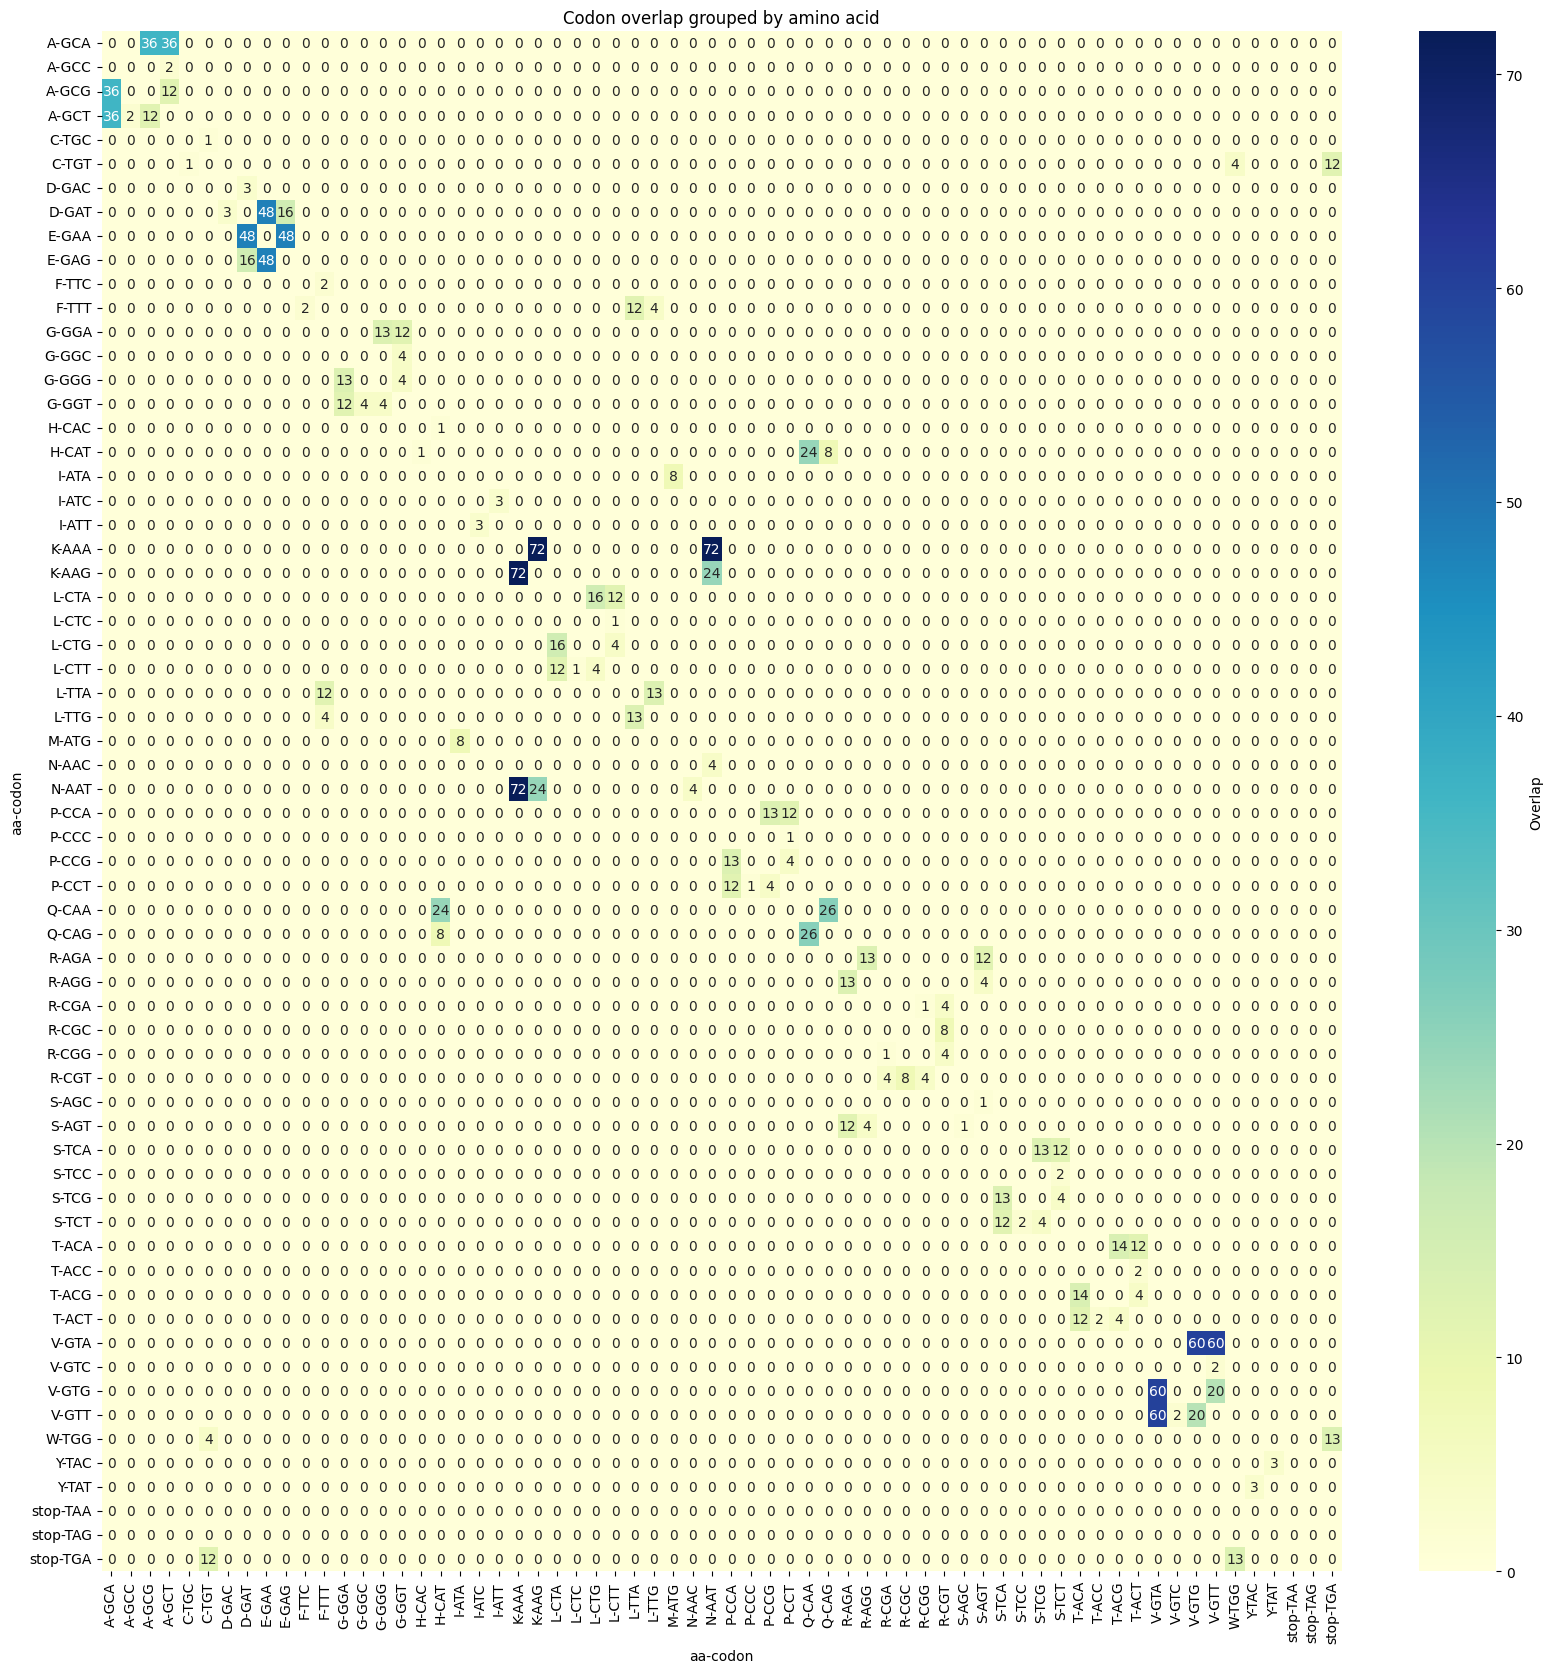

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(display_heatmap_df_sorted, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Overlap'})
plt.title("Codon overlap grouped by amino acid")
plt.xlabel("aa-codon")
plt.ylabel("aa-codon")
plt.show()


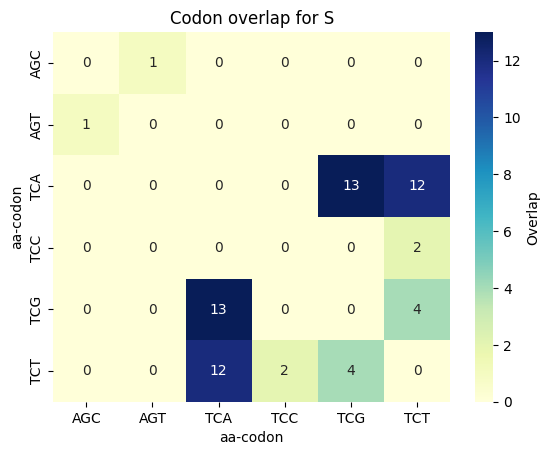

In [13]:
aa = "S"
sns.heatmap(display_heatmap_df_sorted.loc[aa,aa], annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Overlap'})
plt.title(f"Codon overlap for {aa}")
plt.xlabel("aa-codon")
plt.ylabel("aa-codon")
plt.show()
